Install imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import spacy
import csv
import sys
import re
import nltk
import io
import pickle
import os
import datetime
import matplotlib.pyplot as plt
nltk.download("popular")

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow import keras
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from google.colab import files
from nltk.translate.bleu_score import sentence_bleu

stopwords = stopwords.words('english')
max_article_len = 650 #Calculated from averages
max_summary_len = 55

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [2]:
!pip install rouge
from rouge import Rouge

Mount google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Split test/train data into article and summary. Calls methods to clean article and remove stop words.

In [4]:
def split_data(data):
    """Split by highlights (target summary) and the article"""

    articles = []
    summary = []

    articles_length = []
    summary_length = []
    
    for row in data.take(150000):
        article = np.array(row['article']).tolist().decode('utf-8')
        highlight = np.array(row['highlights']).tolist().decode('utf-8')
        articles_length.append(count_words(article))
        summary_length.append(count_words(highlight))
        
        # Clean article
        article = clean_article(article)
        highlight = clean_article(highlight)

        # Remove stop words
        articles.append(remove_stop_words(article))
        summary.append(remove_stop_words(highlight))

    print("The average length is: ",np.average(articles_length))
    print("The average length is: ",np.average(summary_length))

    return articles, summary

Remove certain words/patterns from article

In [5]:
def clean_article(article):
    """Cleans article by replacing certain regex content in the article, and expand contractions"""
    article = article.replace('\n', ' ').replace('(CNN)', '').replace('--', '')
    article=re.sub(r'>',' ', article)
    article=re.sub(r'<',' ', article)
    article=re.sub(r'LRB',' ', article)
    article=re.sub(r'RRB',' ', article)
    article = re.sub(r'[" "]+', " ", article)
    article=re.sub(r"([?!¿])", r" \1 ", article)
    article=re.sub(r'-',' ', article)
    article=article.replace('/',' ')
    article=re.sub(r'\s+', ' ', article)
    article=decontract(article)
    article = re.sub('[^A-Za-z0-9.,]+', ' ', article)
    article = re.sub(r'\s+', ' ', article)

    return article.lower()

Expand word contractions

In [6]:
def decontract(phrase):
    """Expand common contractions in the dataset"""
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'m", " am", phrase)  
    phase = re.sub(r"ain\'t", "is not", phrase) 
    return phrase

Remove stop words

In [7]:
def remove_stop_words(article):
    """Remove stop words (using nltk corpus)"""
    word_token = word_tokenize(article)
    return ' '.join([word for word in word_token if word not in stopwords])

Count number of words to get averages

In [8]:
def count_words(article):
    """Return number of words in an article/summary"""
    split = article.split()
    num_words = len(split)
    return num_words

Preprocesses the train/test data (tokenization, padding, load glove embeddings). Then calls the summarization model.

---



In [9]:
def preprocess_cnn_dm(train_articles_all, train_summary_all, test_articles, test_summary):
    """Preprocess cnn/dm data for summarization
    - Tokenization, padding
    """
    #------------------
    # Article tokenization + padding
    #------------------
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_articles_all)

    # Define rare words (below threshold) as 'ukn'
    threshold=2
    rare_words=[]
    for key,value in tokenizer.word_counts.items():
        if(value<threshold):
            rare_words.append(key)
    
    print("Num of rare words for articles:", len(rare_words))
    rare_words[:5]
    
    token_rare=[]
    for i in range(len(rare_words)):
        token_rare.append('ukn')
    
    rare_words_dict = dict(zip(rare_words,token_rare))

    train_articles=[]
    for i in train_articles_all:
        for word in i.split():
            if word.lower() in rare_words_dict:
                i = i.replace(word, rare_words_dict[word.lower()])
        train_articles.append(i)

    tokenizer = Tokenizer(oov_token='ukn')
    tokenizer.fit_on_texts(list(train_articles))

    #Create training sequence
    train_sequences = tokenizer.texts_to_sequences(train_articles) # x train
    print(train_sequences[0])

    #Create testing sequence
    test_sequences = tokenizer.texts_to_sequences(test_articles) # x test
    
    #Padding
    train_padded = pad_sequences(sequences = train_sequences, maxlen=max_article_len, padding='post')
    print(len(train_sequences[0]))
    print(len(train_padded[0]))
    print(train_padded[0])

    test_padded = pad_sequences(sequences = test_sequences, maxlen=max_article_len, padding='post')
    print(test_padded.shape)

    article_vocab_size = len(tokenizer.word_index) + 1

    #------------------
    # Summary tokenization + padding
    #------------------
    y_tokenizer = Tokenizer()
    y_tokenizer.fit_on_texts(train_summary_all)

    # Define rare words as 'ukn'
    threshold = 2
    rare_words=[]
    for key, value in y_tokenizer.word_counts.items():
        if(value<threshold):
            rare_words.append(key)
    
    rare_words[3:10]

    token_rare=[]
    for i in range(len(rare_words)):
        token_rare.append('ukn')

    rare_words_dict = dict(zip(rare_words,token_rare))

    train_summary=[]
    for i in train_summary_all:
        for word in i.split():
            if word.lower() in rare_words_dict:
                i = i.replace(word, rare_words_dict[word.lower()])
        train_summary.append(i)
  
    print(train_summary_all[5])
    print(train_summary[5])

    y_tokenizer = Tokenizer(oov_token='ukn') 
    y_tokenizer.fit_on_texts(list(train_summary))

    #Create training sequence
    sum_train_sequences = y_tokenizer.texts_to_sequences(train_summary) # x train
    print(sum_train_sequences[0])

    #Create testing sequence
    sum_test_sequences = y_tokenizer.texts_to_sequences(test_summary) # x test
    
    #Padding
    sum_train_padded = pad_sequences(sequences = sum_train_sequences, maxlen=max_summary_len, padding='post')
    sum_test_padded = pad_sequences(sequences = sum_test_sequences, maxlen=max_summary_len, padding='post')
    print(sum_test_padded.shape)

    summary_vocab_size = len(y_tokenizer.word_index) + 1

    #------------------
    # GloVe Pre-trained Word Embeddings
    #------------------  
    embeddings_dictionary = dict()

    with io.open('/content/gdrive/MyDrive/glove/glove.6B.50d.txt', encoding='utf8') as glove_embeddings:
      for line in glove_embeddings:
        line = line.split()
        word = line[0]
        vector_dimensions = np.asarray(line[1:],dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

    # Embeddings for article vocab
    embedding_matrix_x = np.zeros((article_vocab_size+1 , 50))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix_x[index] = embedding_vector

    # Embeddings for summary vocab
    embedding_matrix_y = np.zeros((summary_vocab_size+1, 50))
    for word, index in y_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix_y[index] = embedding_vector

    #------------------
    # Call summarization model
    #------------------
    reverse_target_word_index=y_tokenizer.index_word
    reverse_source_word_index=tokenizer.index_word
    target_word_index=y_tokenizer.word_index

    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open('y_tokenizer.pickle', 'wb') as handle:
        pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    model = Summarization(train_padded, test_padded, sum_train_padded, sum_test_padded, max_article_len, max_summary_len, 
        article_vocab_size, summary_vocab_size, reverse_target_word_index, reverse_source_word_index, target_word_index, embedding_matrix_x, embedding_matrix_y, test_articles)
    model.summarization_seq2seq()

Loads CNN/DailyMail dataset.

In [10]:
data = tfds.load('cnn_dailymail', data_dir="~/tensorflow_datasets")

train_data = data['train']
test_data = data['test']

print(data) #PrefetchDataset

train_articles, train_summary = split_data(train_data)
test_articles, test_summary = split_data(test_data)

print("Length of article training data: ", len(train_articles))
print("Length of summary training data: ", len(train_summary))
print("Length of article testing data: ", len(test_articles))
print("Length of summary training data: ", len(test_summary))

print(train_articles[1])
print(train_summary[1])


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete4LTJQ3/cnn_dailymail-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete4LTJQ3/cnn_dailymail-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete4LTJQ3/cnn_dailymail-test.tfrecord


Dataset cnn_dailymail downloaded and prepared to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0. Subsequent calls will reuse this data.
{'test': <PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>, 'train': <PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>, 'validation': <PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>}
The average length is:  691.3530666666667
The average length is:  51.57478666666667
The average length is:  683.5115752828547
The average length is:  55.00931244560488
Length of article training data:  150000
Length of summary training data:  150000
Length of article testing data:  11490
Length of summary training data:  11490
ralph mata internal affairs lieutenant miami dade police department , working division investigates allegations wrongdoing cops . outside office , authorities allege 

Summarization

---



Attention layer (Bahdanau Attention)

In [11]:
class AttentionLayer(Layer):
    """Attention layer sourced from:
    https://github.com/thushv89/attention_keras
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

Display accuracy/loss graphs

In [12]:
def display_accuracy_graph(history):
    """Plots a graph with the accuracy and val_accuracy to help determine best number of epochs"""
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()

In [13]:
def display_loss_graph(history):
    """Plots a graph with the loss and val_loss"""
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'])
    plt.show()

Summarization Seq2Seq model. Uses GRU instead of LSTM.

In [14]:
class Summarization:
    """Seq2Seq Model (encoder-decoder) for summarizing the news articles"""

    #Hyperparameters
    embedding_dim = 50
    output_dim = 50
    epochs = 5 #Repetions was 10
    batch_size = 64
    latent_dim = 256 #latent dimension
    dropout = 0.3
    
    def __init__(self, train_padded, test_padded, sum_train_padded, sum_test_padded, max_article_len, max_summary_len, x_vocab, y_vocab,
        reverse_target_word_index, reverse_source_word_index, target_word_index, embedding_matrix_x, embedding_matrix_y, test_articles):
        self.train_padded = train_padded
        self.test_padded = test_padded
        self.sum_train_padded = sum_train_padded 
        self.sum_test_padded = sum_test_padded
        self.max_article_len = max_article_len
        self.max_summary_len = max_summary_len
        self.x_vocab = x_vocab #Vocab length for the articles
        self.y_vocab = y_vocab #Vocab length for the summary
        self.reverse_target_word_index = reverse_target_word_index
        self.reverse_source_word_index = reverse_source_word_index
        self.target_word_index = target_word_index
        self.embedding_matrix_x = embedding_matrix_x
        self.embedding_matrix_y = embedding_matrix_y
        self.test_articles = test_articles
        
        
    def encoder(self):
        """Encoder"""
        encoder_input = keras.layers.Input(shape=(self.max_article_len,))
        
        # Embedding layer
        encoder_embedding = self.embedding_layer_articles(encoder_input)

        # First GRU (Gated Recurrent Unit)
        encoder_gru_1 = keras.layers.Bidirectional(keras.layers.GRU(self.latent_dim, return_sequences=True, return_state=True))
        encoder_output_1, encoder_forward_state_1, encoder_backward_state_1 = encoder_gru_1(encoder_embedding)
        encoder_output_dropout_1 = keras.layers.Dropout(self.dropout)(encoder_output_1)

        # Second GRU
        encoder_gru_2 = keras.layers.Bidirectional(keras.layers.GRU(self.latent_dim, return_sequences=True, return_state=True))
        encoder_output, encoder_forward_state, encoder_backward_state = encoder_gru_2(encoder_output_dropout_1)

        encoder_state = keras.layers.Concatenate()([encoder_forward_state, encoder_backward_state])

        return encoder_input, encoder_output, encoder_state


    def decoder(self, encoder_state):
        """Decoder"""
        decoder_input = keras.layers.Input(shape=(None, ))

        # Decoder embedding (summary embedding)
        decoder_embedding = self.embedding_layer_summaries(decoder_input)

        # initial state = encoder_states
        decoder_gru = keras.layers.GRU(self.latent_dim*2, return_sequences=True, return_state=True)

        decoder_output, decoder_state = decoder_gru(decoder_embedding, initial_state=[encoder_state])

        return decoder_input, decoder_output, decoder_state, decoder_gru

    def summarization_seq2seq(self):
        """Create Seq2Seq model for summarization using encoder, attention layer and decoder"""
        
        #Create embedding layers for article and summaries
        self.embedding_layer_articles = keras.layers.Embedding(self.x_vocab+1, self.embedding_dim, mask_zero=True,
                                                               weights=[self.embedding_matrix_x], input_length=self.max_article_len, trainable=False)

        self.embedding_layer_summaries = keras.layers.Embedding(self.y_vocab+1, self.embedding_dim, mask_zero=True,
                                                                weights=[self.embedding_matrix_y], input_length=self.max_summary_len, trainable=False)

        #-- Call Encoder --
        encoder_input, encoder_output, encoder_state = self.encoder()
        #Create encoder model for inference later
        encoder_model = keras.models.Model(encoder_input, [encoder_output, encoder_state])

        #-- Call Decoder --
        decoder_input, decoder_output, decoder_state, decoder_gru = self.decoder(encoder_state)

        #Attention layer
        attention_layer = AttentionLayer() 
        attention_output, attention_states = attention_layer([encoder_output, decoder_output])
        
        # Concat attention input and decoder LSTM output
        decoder_concat_input = keras.layers.Concatenate(axis=-1)([decoder_output, attention_output])

        # Dense layer
        decoder_dense = keras.layers.TimeDistributed(keras.layers.Dense(self.y_vocab+1, activation='softmax'))
        decoder_outputs = decoder_dense(decoder_concat_input)

        #Create decoder model for inference
        decoder_model = self.decoder_inference_model(decoder_gru, decoder_input, decoder_dense)

        model = keras.models.Model([encoder_input, decoder_input], decoder_outputs)
        print(model.summary())

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        es = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=1, min_delta=1e-4)
        checkpoint_filepath = '/content/gdrive/MyDrive/summarization_model'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

        history = model.fit([self.train_padded, self.sum_train_padded[:,:-1]], self.sum_train_padded[:,1:], epochs=self.epochs, batch_size=self.batch_size,
            validation_data=([self.test_padded, self.sum_test_padded[:,:-1]], self.sum_test_padded[:,1:]), workers=-1, callbacks=[es, model_checkpoint_callback])
        
        #Get summaries
        self.infer_summary(encoder_model, decoder_model)

        #Accuracy and loss
        display_accuracy_graph(history)
        display_loss_graph(history)

        #---Evaluaton---#
        #Calculate ROUGE
        self.calculate_metrics(encoder_model, decoder_model)

        #---Save Models---#
        #Encoder
        save_model = encoder_model.to_json()
        with open("encoder_model.json", "w") as json_file:
            json_file.write(save_model)
        files.download("encoder_model.json")
        encoder_model.save_weights("encoder_weights.h5")
        files.download("encoder_weights.h5")

        save_model_decode = decoder_model.to_json()
        with open("decoder_model.json", "w") as json_file:
            json_file.write(save_model_decode)
        files.download("decoder_model.json")
        decoder_model.save_weights("decoder_weights.h5")
        files.download("decoder_weights.h5")      

    def decoder_inference_model(self, decoder_gru, decoder_input, decoder_dense):
        """Create decoder model for predicting summaries"""
        # Previous time step
        decoder_state = keras.layers.Input(shape=(self.latent_dim*2, ))
        decoder_intermittent_state_input = keras.layers.Input(shape=(self.max_article_len, self.latent_dim*2))

        decoder_embedding_inference = self.embedding_layer_summaries(decoder_input)
        #predict next word in sequence. Initial state = previous time step
        decoder_output, decoder_state_inference = decoder_gru(decoder_embedding_inference, initial_state=[decoder_state])

        # Attention layer
        attention_layer = AttentionLayer()
        attention_output, attention_state = attention_layer([decoder_intermittent_state_input, decoder_output])
        decoder_inference_concat = keras.layers.Concatenate(axis=-1)([decoder_output, attention_output])

        #Dense layer
        decoder_output_inference = decoder_dense(decoder_inference_concat)

        # Create decoder model
        decoder_inference_output = keras.models.Model([decoder_input, decoder_intermittent_state_input, decoder_state], 
                                        [decoder_output_inference, decoder_state_inference])
        
        return decoder_inference_output

    def sequence_to_article(self, input_sequence):
        """Convert article sequence of indexes to the original article"""
        article_string = ''

        for item in input_sequence:
            if not item == 0:
                article_string = article_string + self.reverse_source_word_index[item] + ' '
        
        return article_string

    def sequence_to_summary(self, input_sequence):
        """Convert summary sequence of indexes to the original (target) summary"""
        summary_string = ''

        for item in input_sequence:
            if (not item == 0 and not item == self.target_word_index['start']) and not item == self.target_word_index['end']:
                summary_string = summary_string + self.reverse_target_word_index[item] + ' '

        return summary_string

    def search(self, sequence, token):
        """Search for token in a text sequence"""
        for i in range(len(sequence)):
            if sequence[i] == token:
                return True
        return False

    def infer_summary(self, encoder_model, decoder_model):
        """Get predicted and original summary of articles"""

        #Make predictions
        for i in range(0,8):
            print("Original article:", self.sequence_to_article(self.test_padded[i]))
            test_article = self.sequence_to_article(self.test_padded[i])
            test_article = re.sub('[^a-z]+', ' ', test_article)

            result = keras.preprocessing.text.text_to_word_sequence(test_article)

            if self.search(result, 'ukn'):
                index=result.index('ukn')
        
                input_org = re.sub('[^a-z]+',' ', self.test_articles[i])
                input_org = keras.preprocessing.text.text_to_word_sequence(input_org)
                ukn_token = input_org[index]

            else:
                ukn_token='ukn'

            print("Target summary:", self.sequence_to_summary(self.sum_test_padded[i]))
            print("Predicted summary:", self.decode_sequence(self.test_padded[i].reshape(1,self.max_article_len), encoder_model, decoder_model, ukn_token))
            print("\n")

    def decode_sequence(self, input_sequence, encoder_model, decoder_model, ukn_token):
        """Generate a summary for an article using models"""

        # Encode Input
        encoder_output, encoder_state = encoder_model.predict(input_sequence)

        # Target sequence of length = 1
        target_sequence = np.zeros((1, 1))

        # Choose 'start' as first word of target summary
        target_sequence[0, 0] = self.target_word_index['start']

        predicted_summary = ''
        summary_generated = False
        while not summary_generated:
            # Create predictions for next token
            token_output, decoder_state = decoder_model.predict([target_sequence, encoder_output, encoder_state])

            # Sample the next token from vocab (greedy search)
            token_index = np.argmax(token_output[0, -1, :])

            if not token_index == 0:
              sampled_token = self.reverse_target_word_index[token_index]

              if not sampled_token == 'end':
                  if (sampled_token=='ukn'):
                      predicted_summary += ' ' + ukn_token 
                  
                  else:
                      predicted_summary += ' ' + sampled_token

              # Break Condition: Reach max length of summaries or find 'end'
              if sampled_token == 'end' or len(predicted_summary.split()) >= (self.max_summary_len - 1):
                  summary_generated = True

              # Update Target Sequence (length 1).
              target_sequence = np.zeros((1, 1))
              target_sequence[0, 0] = token_index

            else:
              summary_generated = True

            # Update internal states
            encoder_state = decoder_state

        return predicted_summary

    def calculate_metrics(self, encoder_model, decoder_model):
        """Calculates the BLEU and Rouge metrics for evaluating the summarization"""
        target_summaries = [] #reference
        summaries = [] #hypothesis
        bleu_scores = []
        
        for i in range(0,100):
            test_article = self.sequence_to_article(self.test_padded[i])
            test_article = re.sub('[^a-z]+', ' ', test_article)

            result = keras.preprocessing.text.text_to_word_sequence(test_article)

            if self.search(result, 'ukn'):
                index=result.index('ukn')
        
                input_org = re.sub('[^a-z]+',' ', self.test_articles[i])
                input_org = keras.preprocessing.text.text_to_word_sequence(input_org)
                print(len(input_org))
                print(len(self.test_articles))
                print(index)
                ukn_token = input_org[index]

            else:
                ukn_token='ukn'

            target = self.sequence_to_summary(self.sum_test_padded[i])
            actual = self.decode_sequence(self.test_padded[i].reshape(1,self.max_article_len), encoder_model, decoder_model, ukn_token)

            target_summaries.append(target)
            summaries.append(actual)
            
            reference = [str(target).split()]
            candidate = str(actual).split()
            bleu_score = sentence_bleu(reference, candidate, weights=(1,0,0,0))
            bleu_scores.append(bleu_score)

        #ROUGE
        rouge = Rouge()
        scores = rouge.get_scores(target_summaries, summaries, avg=True)
        print(scores)

        #BLEU
        avg = sum(bleu_scores) / len(bleu_scores)
        print(avg)

Test GPU is in use

In [15]:
tf.test.gpu_device_name()

'/device:GPU:0'

Preprocesses data and trains model

Num of rare words for articles: 128686
[1385, 530, 145, 357, 207, 70, 362, 398, 87, 200, 211, 1616, 70, 362, 398, 87, 4225, 18748, 2923, 13992, 168, 6154, 2621, 2205, 797, 728, 235, 18748, 929, 27908, 30903, 14801, 1935, 419, 377, 244, 398, 58, 147, 288, 1091, 7354, 4086, 559, 1536, 98, 6923, 99, 20752, 4225, 255, 175211, 97, 18748, 2923, 13992, 168, 6154, 2621, 2205, 797, 728, 235, 18748, 929, 27908, 30903, 14801, 58, 28773, 782, 447, 8622, 13764, 35, 515, 695, 185, 325, 440, 3197, 6, 473, 4086, 13992, 553, 202, 4225, 255, 175211, 228, 10, 1785, 14801, 1583, 13992, 35, 5977, 2624, 6669, 312, 3140, 843, 3018, 26366, 9362, 1232, 11, 109, 1934, 14801, 660, 5023, 18695, 859, 8377, 11464, 11192, 11052, 18748, 2923, 13992, 168, 6154, 97, 4225, 2201]
127
650
[  1385    530    145    357    207     70    362    398     87    200
    211   1616     70    362    398     87   4225  18748   2923  13992
    168   6154   2621   2205    797    728    235  18748    929  27908
  30903  14801   1935   

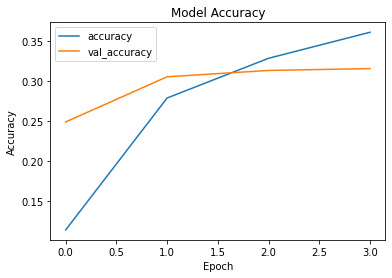

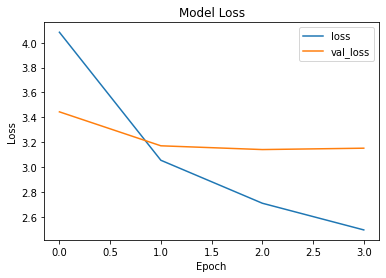

194
11490
71
172
11490
120


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


208
11490
13
188
11490
56
411
11490
11
472
11490
156
669
11490
97
343
11490
6
883
11490
40
270
11490
253
429
11490
28
221
11490
82
489
11490
3
166
11490
45
436
11490
25
664
11490
6
904
11490
378
555
11490
88
150
11490
14
625
11490
17
570
11490
272
483
11490
129


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


425
11490
122
364
11490
79
234
11490
70
314
11490
70
255
11490
161
309
11490
38
202
11490
141
647
11490
271
243
11490
13
254
11490
6
372
11490
275
324
11490
33
210
11490
74
321
11490
187
311
11490
107
201
11490
30
177
11490
133
367
11490
186
397
11490
255
318
11490
21
716
11490
9
344
11490
10
786
11490
21
242
11490
217
383
11490
49
262
11490
17
414
11490
94
159
11490
19
214
11490
32
408
11490
267
563
11490
150
520
11490
61
786
11490
39
444
11490
80
288
11490
57
258
11490
26
217
11490
25
81
11490
6
156
11490
152
429
11490
11
474
11490
20
389
11490
129
252
11490
14
387
11490
256
695
11490
178
{'rouge-1': {'f': 0.05176125850433072, 'p': 0.041501687043538286, 'r': 0.07986693109964071}, 'rouge-2': {'f': 0.006346860254054298, 'p': 0.005332939329433017, 'r': 0.008939203626274563}, 'rouge-l': {'f': 0.0517657767098821, 'p': 0.03696376008036064, 'r': 0.09866788239280495}}
0.029260666431127375


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
preprocess_cnn_dm(train_articles, train_summary, test_articles, test_summary)